## Contributions

In [1]:
%run setup.ipynb
import json
from scipy.stats import chi2
import sys

In [2]:
cwd = os.getcwd()
base_dir = os.path.abspath(os.path.join(cwd, "../"))  # For interactive mode (Jupyter/IPython)
pythonPath = os.path.join(base_dir, 'python', 'nonstationaryGEV')
sys.path.append(pythonPath)

from imports import make_directoryDict
from plotting import plotTimeDependentReturnValue
from helpers import adjust_w_for_plotting


In [3]:
# set up directories to read from
dirs = make_directoryDict(base_dir)

In [4]:
recordID =57
climateIndex = ['AO','AAO','BEST','DMI','ONI','PDO','PMM','PNA','TNA']

In [5]:
#%%
# Initialize an empty list to store results
results = []
SignifCvte1 = np.zeros(len(climateIndex))
w_nodal = np.zeros(len(climateIndex))
w_cvte1 = np.zeros(len(climateIndex))

for i in np.arange(0, len(climateIndex)):

    #read first value of w from trend_params.json
    nodal_params = 'nodal_params.json'
    jsonpath = Path(dirs['model_output_dir']) / str(recordID) / nodal_params
    with open(jsonpath, 'r') as f:
        output = json.load(f)
        w_nodal[i] = output['w'][0]

    covariate_params = f'cvte_location_params_{climateIndex[i]}.json'
    
    # Create the full path for the JSON file
    jsonpath = Path(dirs['model_output_dir']) / str(recordID) / covariate_params

    # Open and read the JSON file
    with open(jsonpath, 'r') as f:
        output = json.load(f)
        w, mio, standard_error,x = (np.array(output[key]) for key in ['w', 'mio', 'standard_error','x'])

    wfull = adjust_w_for_plotting(x,w)
    standard_error = adjust_w_for_plotting(x,standard_error)

    # Store the results in a list
    results.append({
        'Climate Index': climateIndex[i],
        'CI param': wfull[10],  
        'Standard Error of CI param': standard_error[10]
    })

    # Compute deviance statistic
    w_cvte1[i] = w[0]
    diffe = w_cvte1[i] - w_nodal[i]
    p = 1
    SignifCvte1[i] = chi2.cdf(2 * diffe, p)

# Convert the results list to a DataFrame
df_cvteLocation = pd.DataFrame(results)

# add Significance to the dataframe
df_cvteLocation['Significance (over Nodal)'] = SignifCvte1

df_cvteLocation


,Climate Index,CI param,Standard Error of CI param,Significance (over Nodal)
0,AO,0.003866,0.004946,0.601864
1,AAO,0.002109,0.004978,0.371094
2,BEST,0.001448,0.004963,0.309634
3,DMI,-0.005647,0.004949,0.864522
4,ONI,-0.001762,0.004966,0.385205
5,PDO,0.018253,0.004874,0.999984
6,PMM,0.021845,0.004774,1.000000
7,PNA,-0.006032,0.004917,0.785168
8,TNA,0.007026,0.004996,0.922323


Text(0.5, 0, 'Climate Index')

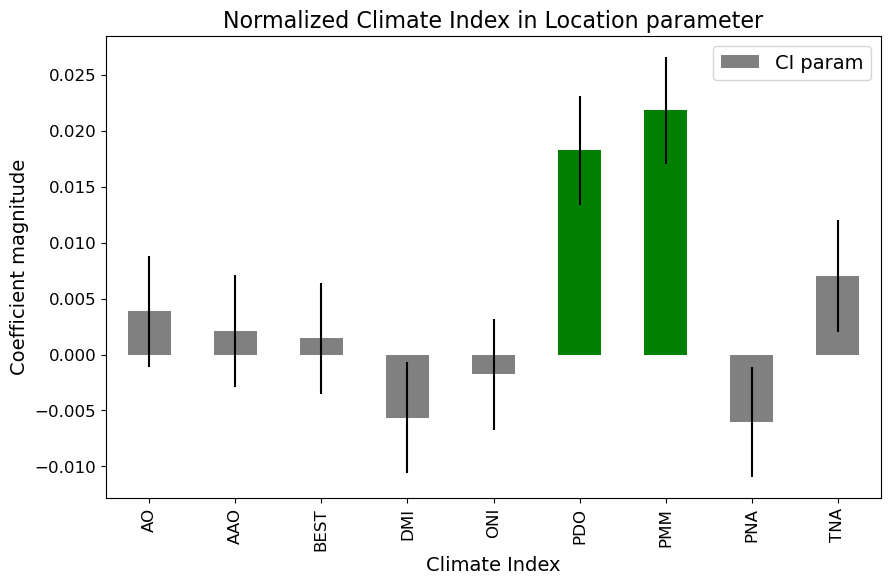

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Define colors based on significance
location_colors = np.where(df_cvteLocation['Significance (over Nodal)']>0.95, 'green', 'gray')

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot the Location parameter with custom colors for significance
df_cvteLocation.plot(
    x='Climate Index', 
    y='CI param', 
    yerr='Standard Error of CI param', 
    kind='bar',  
    ax=ax,
    color=location_colors
)
ax.set_title('Normalized Climate Index in Location parameter')
ax.set_ylabel('Coefficient magnitude')
ax.set_xlabel('Climate Index')




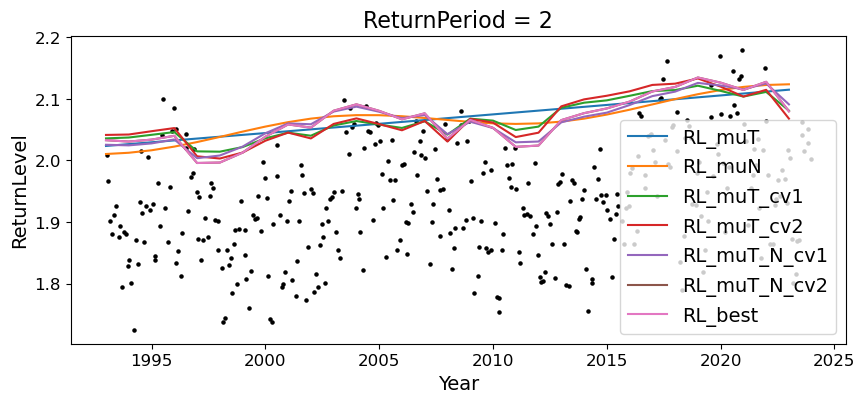

In [22]:
# load in the best model from C:\Users\julia\Documents\GitHub\SL_Hawaii\data\GEV_model_output\57\RL_best.nc
# and plot the return level curve

modelTypes = ['RL_muT', 'RL_muN','RL_muT_cv1','RL_muT_cv2','RL_muT_N_cv1','RL_muT_N_cv2','RL_best']

for modelType in modelTypes:
    modelName = modelType + '.nc'
    modelPath = Path(dirs['model_output_dir'] / str(recordID) / modelName)
    model = xr.open_dataset(modelPath)

    model['ReturnLevel'].sel(ReturnPeriod=2).plot()

plt.legend(modelTypes)

# read the json file for best model
jsonpath = Path(dirs['model_output_dir']) / str(recordID) / 'best_params.json'
with open(jsonpath, 'r') as f:
    output = json.load(f)
    modelInfo = output['modelInfo']
    params = output['w']
    x = output['x']

time = modelInfo['year0'] + pd.Series(modelInfo['t'])
plt.scatter(time, modelInfo['monthlyMax'], color='k', label='Monthly Maxima', s=5)



In [53]:

w = adjust_w_for_plotting(x, params)

def plot_location(w, modelInfo, label, offset=0):
    b0, b1, b2, b3, b4, b5, b6 = w[0], w[3], w[4], w[5], w[6], w[7], w[8]
    a0, bLT, bCI, aCI, bN1, bN2 = w[1], w[9], w[10], w[11], w[12], w[13]

    ti = pd.Series(modelInfo['t'])+modelInfo['year0']
    CI = pd.Series(modelInfo['covariate'])

    # Define mut (location(t)) and other parameters
    mut = (b0 * np.exp(bLT * ti) +
               b1 * np.cos(2 * np.pi * ti) + b2 * np.sin(2 * np.pi * ti) +
               b3 * np.cos(4 * np.pi * ti) + b4 * np.sin(4 * np.pi * ti) +
               b5 * np.cos(8 * np.pi * ti) + b6 * np.sin(8 * np.pi * ti) +
               bN1 * np.cos((2 * np.pi / 18.61) * ti) + bN2 * np.sin((2 * np.pi / 18.61) * ti) +
               (bCI * CI))
    
    mut_demeaned = mut - np.mean(mut)
    plt.plot(ti, mut+offset, label=label)




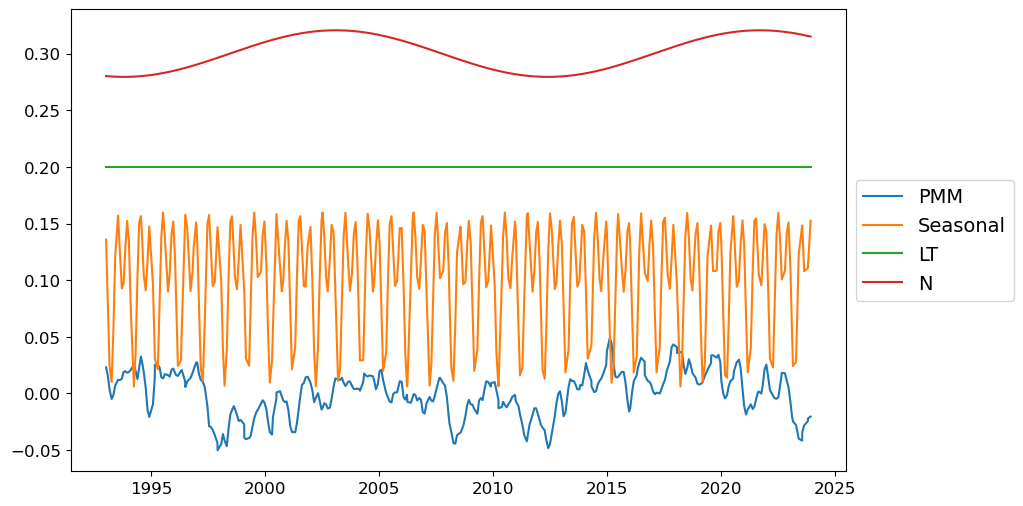

In [55]:
# make figure
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

wnew = np.zeros(len(w))
wnew[10] = w[10]
plot_location(wnew, modelInfo, label=modelInfo['covariateName'],offset = 0)

wnew = np.zeros(len(w))
wnew[1:9] = w[1:9]
plot_location(wnew, modelInfo, label='Seasonal',offset = 0.10)

wnew = np.zeros(len(w))
wnew[9] = w[9]
plot_location(wnew, modelInfo, label='LT',offset = 0.20)

wnew = np.zeros(len(w))
wnew[12:14] = w[12:14]
plot_location(wnew, modelInfo, label='N',offset = 0.30)

# add legend to outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
